<div id="container" style="position:relative;">
<div style="float:left"><h1> Boosting </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>

For today's lecture, make sure you are using the `boosting` environment/kernel. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Some of these packages will generate a ton of warnings...
import warnings
warnings.filterwarnings("ignore")

We will now continue with ensemble methods and look at boosting. Previously we've seen bootstrap aggregation (bagging) which is the training of several models in parallel. Now, instead of training models which are unaware of each other, we will train models sequentially, where each new model compensates for the weaknesses of the previous models.

Let's define some helper functions we've used:

In [2]:
def PlotBoundaries(model, X, Y, figsize=(10,7)) :
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''
    
    x_padding = max(int(0.1*(X[:, 0].max() - X[:, 0].min())), 1)
    y_padding = max(int(0.1*(X[:, 1].max() - X[:, 1].min())), 1)
    
    x_resolution, y_resolution = 0.1, 0.1
    
    x_min, x_max = X[:, 0].min() - x_padding, X[:, 0].max() + x_padding
    y_min, y_max = X[:, 1].min() - y_padding ,X[:, 1].max() + y_padding
    xx, yy = np.meshgrid(np.arange(x_min, x_max, x_resolution), np.arange(y_min, y_max, y_resolution))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.ylim(y_min, y_max)

    #Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
    plt.show()

In [3]:
def PlotEnsembleBoundaries(ensembles, X, Y, shape, figsize=(10,7)) :
    '''
    Helper function to plot the boundaries of ensemble methods.
    code modified from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html
    '''
    
    x_padding = max(int(0.1*(X[:, 0].max() - X[:, 0].min())), 1)
    y_padding = max(int(0.1*(X[:, 1].max() - X[:, 1].min())), 1)
    
    
    x_resolution, y_resolution = 0.1, 0.1
    
    plt.figure(figsize=figsize)
    fig, axes = plt.subplots(shape[0],shape[1], figsize=figsize)
    for i, (ax, model) in enumerate(zip(axes.ravel(), ensembles)):
        x_min, x_max = X[:, 0].min() - x_padding, X[:, 0].max() + x_padding
        y_min, y_max = X[:, 1].min() - y_padding, X[:, 1].max() + y_padding
        xx, yy = np.meshgrid(np.arange(x_min, x_max, x_resolution), np.arange(y_min, y_max, y_resolution))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.4)

        #Plot
        ax.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax.set_ylim(y_min, y_max)

    plt.show()

There's two different boosting algorithms that we will look at: 
* Adaptive Boosting
* Gradient Boosting

### AdaBoost

Our first boosting algorithm will be Adaptive Boosting also known as AdaBoost. AdaBoost was the original boosting implementation. It's been mostly replaced with other boosting algorithms now, but it still serves as a good introduction.

### How it Works

AdaBoost works by fitting a sequence of weak models, usually depth one decision trees (decision stumps), each of which is trained to focus on examples the previous models got wrong. This is accomplished by re-weighting each data point so the misclassified ones contribute more to the error.

To better get an idea of what is going on, let's train an AdaBoost (of two decision stumps). We'll fit it to the cancer dataset:

In [4]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
#Use two dimensions of cancer for ease of visualization.
X = cancer.data[:,[1,3]]
y = cancer.target

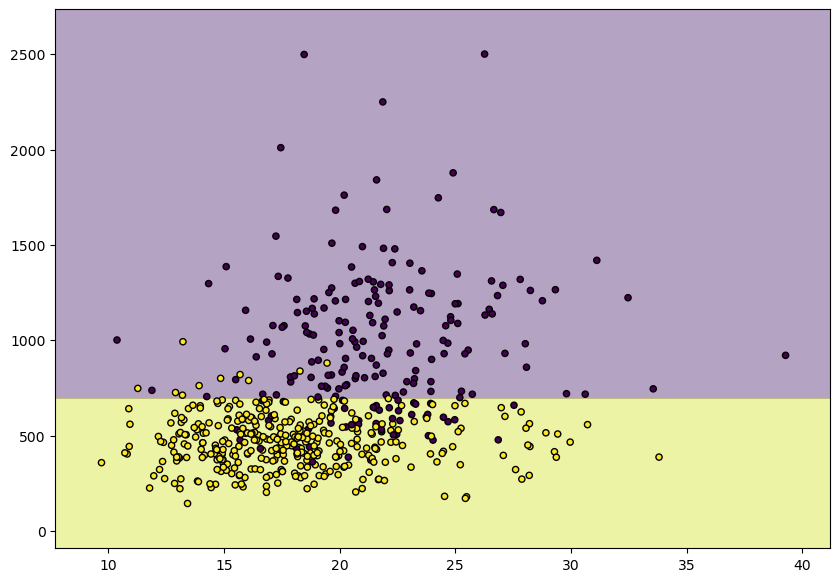

In [5]:
from sklearn.ensemble import AdaBoostClassifier

#fitting Adaptive Boosting
AdaBoost_model = AdaBoostClassifier(n_estimators=2)
AdaBoost_model.fit(X, y)

# Plotting decision regions
PlotBoundaries(AdaBoost_model, X, y)

This looks just like a decision stump. It's a pretty simple, but also accurate, decision boundary. To understand why the model is so simple let's look at each ensemble component.

Let's look at the two components of the model:

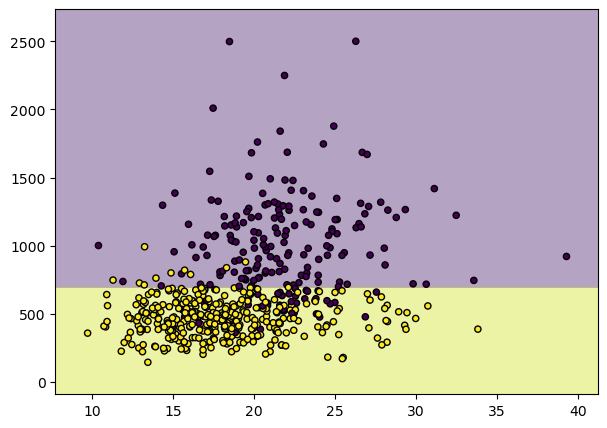

In [6]:
models = [AdaBoost_model.estimators_[0], AdaBoost_model.estimators_[1]];
PlotBoundaries(models[0], X, y, figsize=(7,5)) 

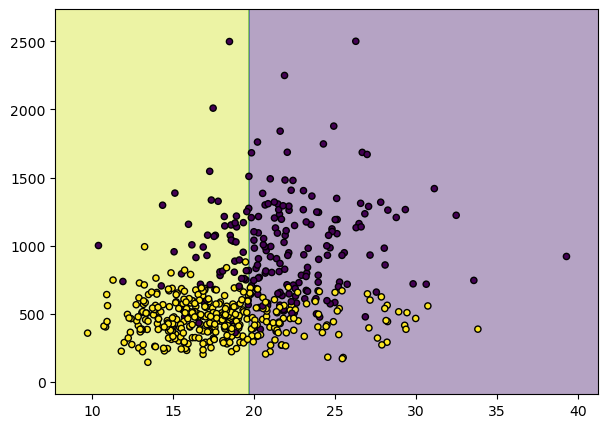

In [7]:
PlotBoundaries(models[1], X, y, figsize=(7,5))

The first boundary looks reasonable, but the second looks terrible! It mislabels a ton of points on each side of the divide. Why is it doing this? 

Recall that we said AdaBoost works by re-weighting each data point when fitting new stumps. After the first iteration, it was able to classify most of the points correctly, but there were a few mistakes. For the next iteration it put all of its effort on classifying these missed points, ignoring what was previously correct. This is the first strength of AdaBoost: it learns to focus on points it has done poorly on, it can adjust its fitting strategy to deal with observed weakness.

Once we have more than one classifier, how do we combine their prediction? Like the bagging-based ensemble methods we saw before, there is a form of averaging going on where each sub-model contributes to the decision. But now the contribution of each model is unequal. Let's visualize the three models, the ensemble and its two components, side by side. 

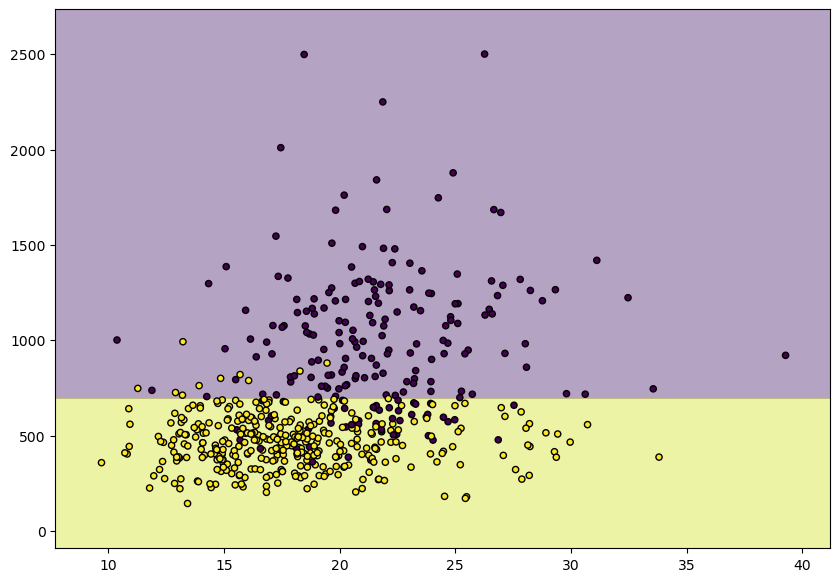

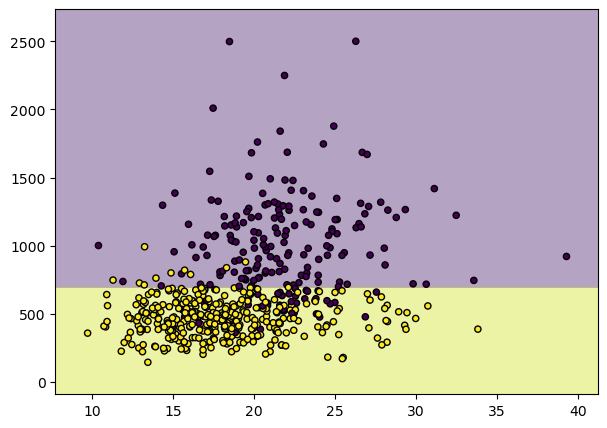

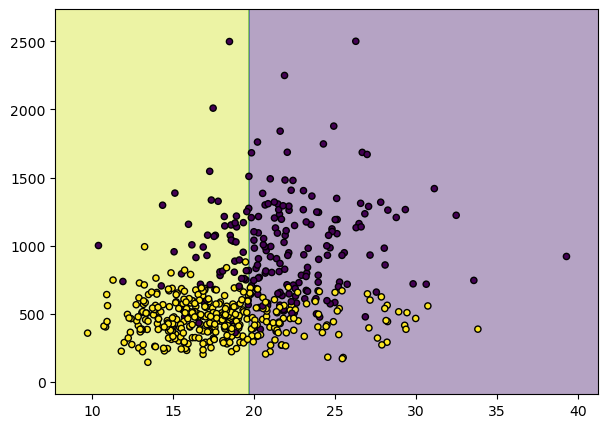

In [8]:
#First model is the ensemble, second is the first tree, third is the second tree.
PlotBoundaries(AdaBoost_model, X, y) 
PlotBoundaries(models[0], X, y, figsize=(7,5)) 
PlotBoundaries(models[1], X, y, figsize=(7,5)) 

The full ensemble is the first plot while its components are the next two. The ensemble has essentially ignored the second model, it's only considering the decision made by the first. The first sub-model is superior from an accuracy standpoint, it got a much higher classification accuracy. 

When averaging the decisions of each sub-model AdaBoost re-weights their contribution by how accurate they are. This is the second strength of AdaBoost, it learns to focus on the best models within its ensemble. 

Since our previous example only contained two sub-models, the benefit of re-weighting the training points and the sub-models wasn't totally apparent. But let's run a larger example with 50 sub-models:

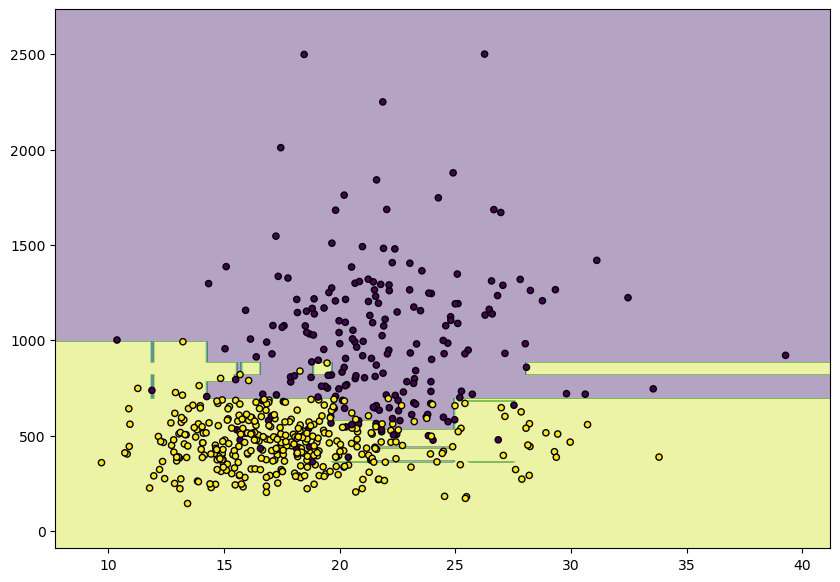

In [9]:
from sklearn.ensemble import AdaBoostClassifier

#fitting the Booster
AdaBoost_model = AdaBoostClassifier(n_estimators=50)
AdaBoost_model.fit(X, y)

# Plotting decision regions
PlotBoundaries(AdaBoost_model, X, y) 

We see that the decision boundary is quite complex, it looks like the boundaries of a decision tree or random forest. If we look at some of the underlying ensemble components we see each is quite simple:

<Figure size 1000x700 with 0 Axes>

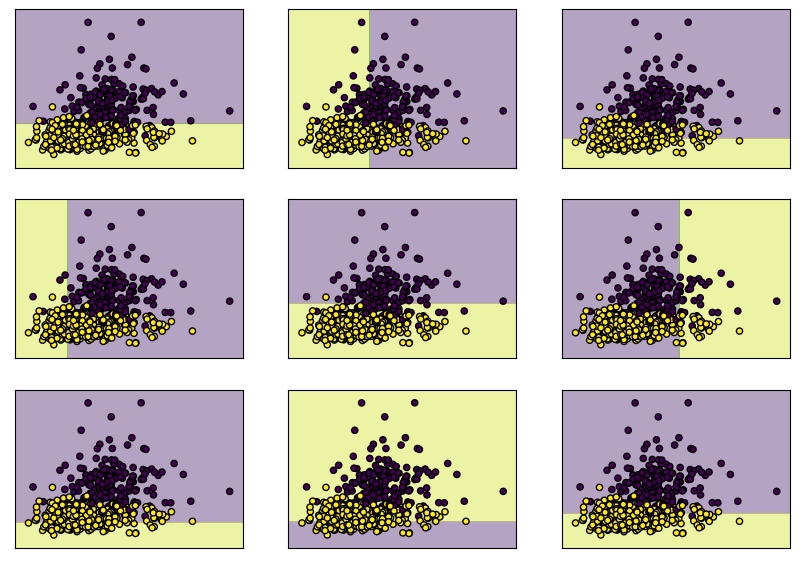

In [10]:
models = []
for i in range(9) :
    models.append(AdaBoost_model.estimators_[i])
    
PlotEnsembleBoundaries(models, X, y, (3,3));

Notice the reweighting of data points changes the decision boundaries. There are some sub-models which get most of the underlying points wrong, they do this so they can learn to identify previously missed points. Even though some of these sub models are bad from an objective perspective they are weighted down in the final averaging.

### Fitting AdaBoost

Let's formalize the AdaBoost algorithm now:

1. Weight each data point in an equal fashion
2. For `n_estimators` steps :
    1. Fit a new model $M_i$ to the weighted data
    2. Calculate the weighted error of $M_i$ on the data
    3. Using (2) calculate $M_i$'s contribution to the model (scale this with `learning_rate`)
    4. Weight each data point based on the new model performance
3. Return the model which is all of the individual $M_i$ models weighted by their contribution.

Now that we know how each sub-model is fit in sequence and how the overall decision is aggregated together, how do we actually train the entire ensemble? When fitting the ensemble to the training set we keep adding in new sub-models until the entire model achieves perfect accuracy. This can take quite a while and tends to overfit. In practice we tend to limit the number of sub-models using `n_estimators`, by default this is set to $50$.

### Illustration of Adaptive Boosting
To further learn about the steps this method, we will use some great illustrations from: 

https://realpython.com/traditional-face-detection-python/#adaboost

Let's assume we have some data from two classes:

<img src = "https://drive.google.com/uc?export=view&id=1e7SzVk-25qLPjhM5mRCmJtcGlIiMvLww">
<center><i>(Image Source: <a>https://files.realpython.com/media/AdaBoost-1.f0eacdf0c2e2.png</a>)</i></center>


**Stump #1**

We use one stump to classify the data points as best as possible:

<img src = "https://drive.google.com/uc?export=view&id=1f_2XolFEV14sprRAcdv2IpaftNy15QCd">
<center><i>(Image Source: <a>https://files.realpython.com/media/AdaBoost-2.03c3c6a0c34f.png</a>)</i></center>

We misclassify the three blue points, so more weight is put on correctly classifying them in the next model: 

<img src = "https://drive.google.com/uc?export=view&id=1pbh_w0Ai1Wc6Ru8htu9fcGsDEY8KbuWs">
<center><i>(Image Source: <a>https://files.realpython.com/media/AdaBoost-3.2d874993bc92.png</a>)</i></center>

**Stump #2**

We got the three blue points but now we misclassify the three orange points:

<img src = "https://drive.google.com/uc?export=view&id=1nrGHlL0a1E07pB7ipdkViPk0hUKyXPqC">
<center><i>(Image Source: <a>https://files.realpython.com/media/AdaBoost-4.705558b218f3.png</a>)</i></center>

So more weight is put on correctly classifying them in the next model:

<img src = "https://drive.google.com/uc?export=view&id=1WBcybJvtTtqoMhO2P6XRXO-EVVJ2VgBp">
<center><i>(Image Source: <a>https://files.realpython.com/media/AdaBoost-5.1d800ca4ffff.png</a>)</i></center>

**Stump #3**

This model manages to classify those orange points correctly:

<img src = "https://drive.google.com/uc?export=view&id=1M3-cXgH7E0HaY7Kjv-5fEg2L19EXe4bl">
<center><i>(Image Source: <a>https://files.realpython.com/media/AdaBoost-6.ac0a9accb5f7.png</a>)</i></center>

**Putting all sumps together** 

We have now build a very strong classifier made up of many weak classifiers:

<img src = "https://drive.google.com/uc?export=view&id=14HUrLfdBT_TKIbz88hNtnVPMhcq_Ug62">
<center><i>(Image Source: <a>https://files.realpython.com/media/AdaBoost-7.2ec2db197252.png</a>)</i></center>

### Why Use Decision Stumps?

Recall that with a Random Forest, we wanted each member of our ensemble to overfit to the data and to have this overfitting disappear when the members' results are averaged out. Because of this, we used deep decision trees as our base learners where each tree learns a biased representation of the data, but on average the representation is (usually) good.

Boosting takes a different approach. We want to refocus the model's attention on examples it has struggled with in the past. We don't want to be drawn away from the re-weighted points by noise in the data. We want the simplest classifier possible that can focus on correcting previous mistakes. That being said, AdaBoost, or other boosting algorithms, can use deeper trees or even different classifiers. Indeed, many high performing boosting ensembles end up tuning the inner parameters of all of their models.

### Comparing Various Trees

At this point you may be wondering: Are all the decision tree methods we've seen any different? They all seem to learn similar looking boundaries. Is one superior to another? The answer is task-dependent. In practice, AdaBoost tends to beat out Bagging with decision trees (random forests) and vanilla decision trees. But in general we can't say one model is always superior to another. 

Boosting is nice since it tends to work well out of the box. Let's run an experiment where we use the entire cancer dataset, (so now we can't visualize the underlying dimensions), and try out a bunch of different models:

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=3)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

AB_model = AdaBoostClassifier()
DT_model = DecisionTreeClassifier()
RF_model = RandomForestClassifier()

AB_model.fit(X_train, y_train)
DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)

print("Test Set Scores:")
print(f"AdaBoost score: {AB_model.score(X_test,y_test)}")
print(f"Random Forest score: {RF_model.score(X_test,y_test)}")
print(f"Decision Tree score: {DT_model.score(X_test,y_test)}")

Test Set Scores:
AdaBoost score: 0.9736842105263158
Random Forest score: 0.9649122807017544
Decision Tree score: 0.9254385964912281


AdaBoost was the best classifier here, but only marginally so. The data set we're using is pretty clean and nice to work with. This is unlike real data which tends to have more noise. Let's re-run the experiment after adding in some noise to the features, (this will take a minute):

In [14]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Add some noise to the data (notice how I'm adding on the noise here)
random_state = np.random.RandomState(10)

n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 300*n_features)]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=3)

In [15]:
X.shape

(569, 9030)

In [16]:
AB_model = AdaBoostClassifier()
DT_model = DecisionTreeClassifier()
RF_model = RandomForestClassifier()

AB_model.fit(X_train, y_train)
DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)

print("Test Set Scores:")
print(f"AdaBoost score: {AB_model.score(X_test,y_test)}")
print(f"Random Forest score: {RF_model.score(X_test,y_test)}")
print(f"Decision Tree score: {DT_model.score(X_test,y_test)}")

Test Set Scores:
AdaBoost score: 0.9692982456140351
Random Forest score: 0.9517543859649122
Decision Tree score: 0.8947368421052632


AdaBoost still outperforms the other two models.

---
#### Exercise 1
1. Fit an AdaBoost model to the following dataset, which you can download [here](https://api.brainstation.io/content/link/1VuPlKGtlR8BsS8Z_rGbTCqZ_j7uxu-Hg). Try adjusting the number of estimators. What patterns are you seeing?
2. Try redoing the previous exercise but adjust the learning rate parameter, you can use double and half the default value.
---

In [17]:
data = pd.read_csv("data/db.csv")

X = data.iloc[:,0:7]
y = data.iloc[:,8]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=3)


In [18]:
from sklearn.model_selection import cross_val_score

cv_scores = []
n_est_range = list(range(1, 150, 5))

for n_est in n_est_range:
    ada = AdaBoostClassifier(n_estimators=n_est)
    cv_scores.append(np.mean(cross_val_score(ada, X_train, y_train, cv=5)))
    
    print(n_est, end = '\r')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


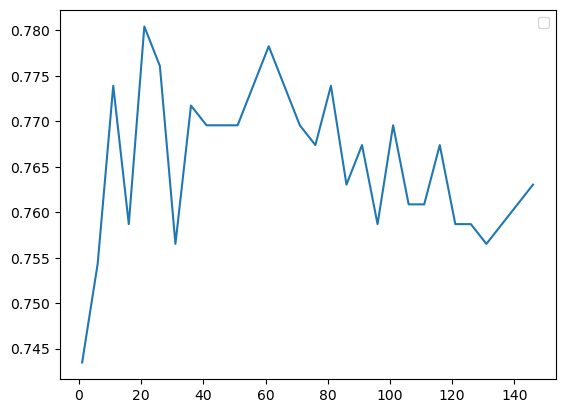

In [19]:
plt.plot(n_est_range, cv_scores)
plt.legend()
plt.show()

In [20]:
from sklearn.model_selection import cross_val_score

cv_scores = []
lr_range = list(np.arange(0, 2, 0.05))

for lr in lr_range:
    ada = AdaBoostClassifier(n_estimators=20, learning_rate=lr)
    cv_scores.append(np.mean(cross_val_score(ada, X_train, y_train, cv=5)))
    
    print(lr, end = '\r')



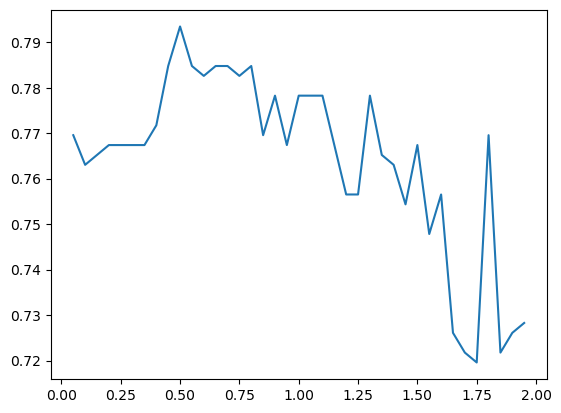

In [21]:
plt.plot(lr_range, cv_scores)
plt.show()

### Gradient Boosting

Recall that one strength of AdaBoost was its ability to refocus its attention on data points where it performed poorly. It does this by re-weighting the contribution of misclassified points to the error. This allowed the overall model to fit sub-models that could correct for the mistakes of the previous ones. This is one way of guiding each sub-model. Another common and more general technique is called Gradient Boosting. 

The Gradient Boosting algorithm fits each sub-model to the residuals of the previous models. We won't get into the math of this, but it is a much more general classifier. It can optimize for various error functions of the residuals, and it can even simulate the AdaBoost algorithm. 


If you would like to know more about the details of gradient boosting, look at the following: 
* Intuitive Explanation: https://www.youtube.com/watch?v=IXZKgIsZRm0

* Code from Scratch: https://www.kaggle.com/grroverpr/gradient-boosting-simplified/

Let's actually fit Gradient Boosting model to two dimensions of the cancer dataset:

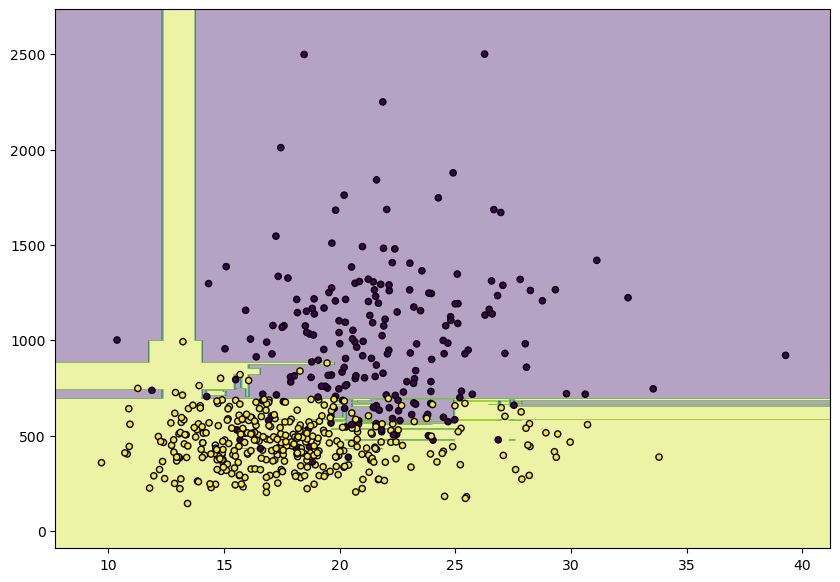

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

#Generate some data
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data[:,[1,3]]
y = cancer.target


#fitting Boosting
grad_boost_model = GradientBoostingClassifier()
grad_boost_model.fit(X, y)

# Plotting decision regions
PlotBoundaries(grad_boost_model, X, y) 

Let's also visualize some of the underlying sub-models. Note, by default each sub-tree is of depth three. This is unlike AdaBoost where the decision trees were of depth one. There does not appear to be any reason for this, it's just an oddity in scikit-learn. You may notice something else odd with the plots...

<Figure size 1000x700 with 0 Axes>

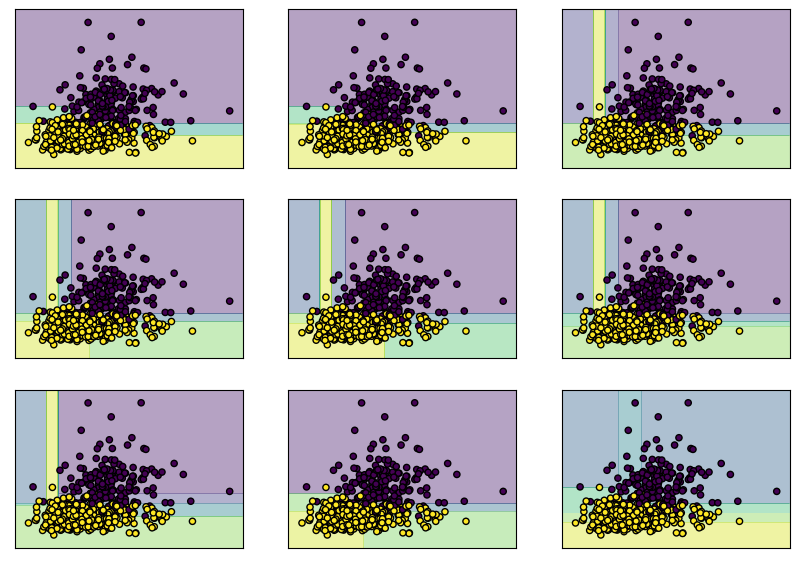

In [23]:
models = []
for i in range(9) :
    models.append(grad_boost_model.estimators_[i][0])
    
PlotEnsembleBoundaries(models, X, y, (3,3));

If we compare the performance of the Gradient Boosting method to the previous tree and ensemble methods (using the noisy cancer data set):

In [24]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Add some noise to the data
random_state = np.random.RandomState(10)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 300*n_features)]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=3)

In [25]:
DT_model = DecisionTreeClassifier()
RF_model = RandomForestClassifier()
AB_model = AdaBoostClassifier()


DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)
AB_model.fit(X_train, y_train)


print("Test Set Scores:")
print(f"Random Forest score: {RF_model.score(X_test,y_test)}")
print(f"Decision Tree score: {DT_model.score(X_test,y_test)}")
print(f"AdaBoost score: {AB_model.score(X_test,y_test)}")


Test Set Scores:
Random Forest score: 0.9342105263157895
Decision Tree score: 0.868421052631579
AdaBoost score: 0.9692982456140351


In [26]:
GB_model = GradientBoostingClassifier(verbose=1)
GB_model.fit(X_train, y_train)
print(f"Gradient Boost score: {GB_model.score(X_test,y_test)}")

      Iter       Train Loss   Remaining Time 
         1           1.1608           55.05s
         2           1.0187           52.64s
         3           0.9018           52.22s
         4           0.8033           51.93s
         5           0.7205           51.28s
         6           0.6395           50.53s
         7           0.5696           49.75s
         8           0.5090           48.97s
         9           0.4561           48.34s
        10           0.4102           47.67s
        20           0.1564           42.53s
        30           0.0695           37.16s
        40           0.0352           31.76s
        50           0.0187           26.44s
        60           0.0103           21.10s
        70           0.0059           15.84s
        80           0.0038           10.62s
        90           0.0024            5.33s
       100           0.0017            0.00s
Gradient Boost score: 0.956140350877193


We see it is pretty comparable to AdaBoost, substantially outperforms decision trees, and will even outperform Random Forests depending on the  test set.

### How does Gradient Boosting Differ from Adaptive Boosting? 

To understand at a high level how these models differ, let's open up the estimators of an AdaBoost and Gradient Boosting model:

In [27]:
#Let's use a smaller dataset.

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=3)

In [28]:
AB_model = AdaBoostClassifier()
GB_model = GradientBoostingClassifier()

AB_model.fit(X_train, y_train);
GB_model.fit(X_train, y_train);

In [29]:
print(type(AB_model.estimators_[0]))

<class 'sklearn.tree._classes.DecisionTreeClassifier'>


In [30]:
#This looks weird... For two reasons...
print(type(GB_model.estimators_[0]))

# alright, let's unpack further?
print(type(GB_model.estimators_[0][0]))

<class 'numpy.ndarray'>
<class 'sklearn.tree._classes.DecisionTreeRegressor'>


In [31]:
GB_model.estimators_[0]

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x1FCB2861A40)],
      dtype=object)

First we should note that they are fitting different base estimators: gradient boosting is using regression trees instead of decision trees. 

### Quick regression tree review

But what is a regression tree? 

If you recall from lesson on decision trees, a regression tree works in the same way as a classification tree, but it predicts a continuous target instead of a categorical one. Let's visualize some simple regression trees. Here we will be working with the California Housing dataset:

In [32]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

# Put into a dataframe
california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df['median_house_value'] = california.target
california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,median_house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [33]:
# Grab only longitude and latitude
X = california_df[['Longitude', 'Latitude']].values
y = california_df['median_house_value']

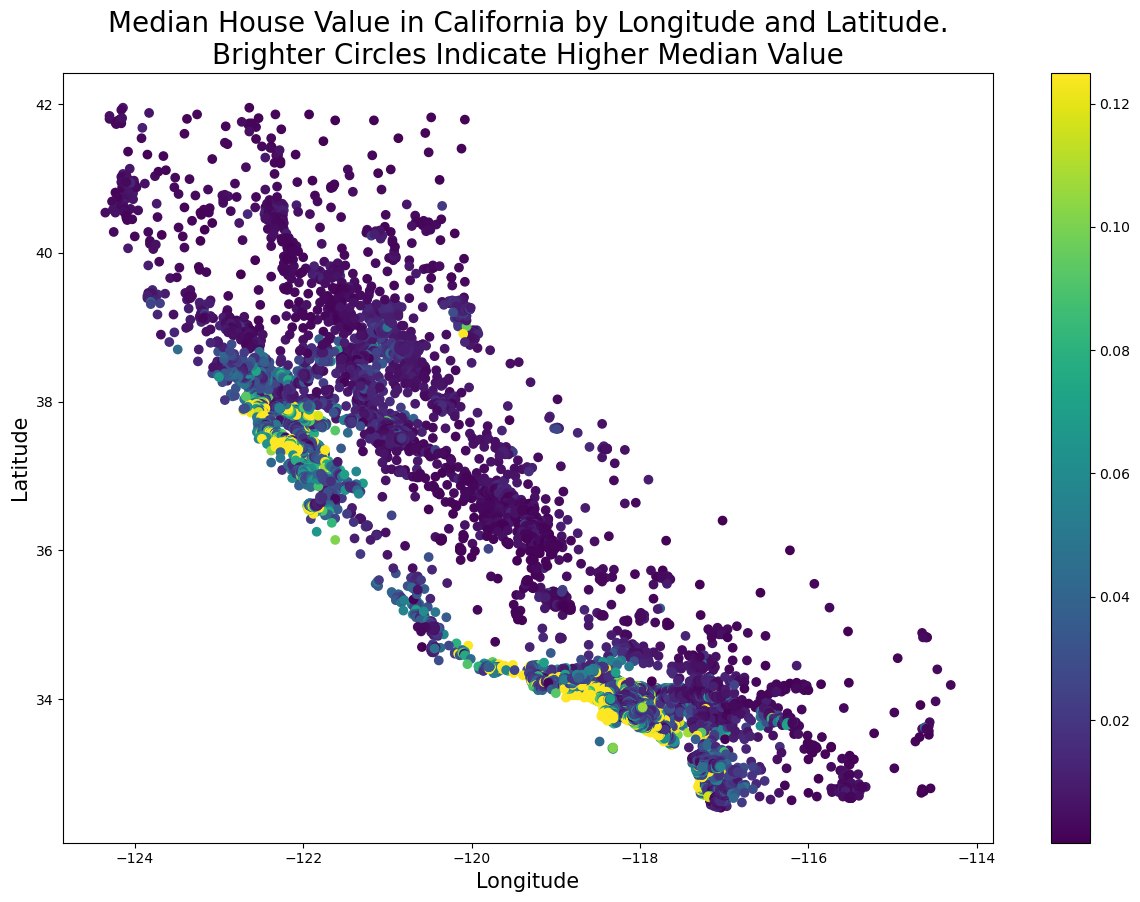

In [34]:
plt.figure(figsize=(15,10))
plt.scatter(X[:,0], X[:, 1], c=(y**2)/200)
plt.title("Median House Value in California by Longitude and Latitude.\
\nBrighter Circles Indicate Higher Median Value", size=20)
plt.xlabel("Longitude", size=15)
plt.ylabel("Latitude", size=15)
plt.colorbar()
plt.show()

We can now fit a decision tree on this data

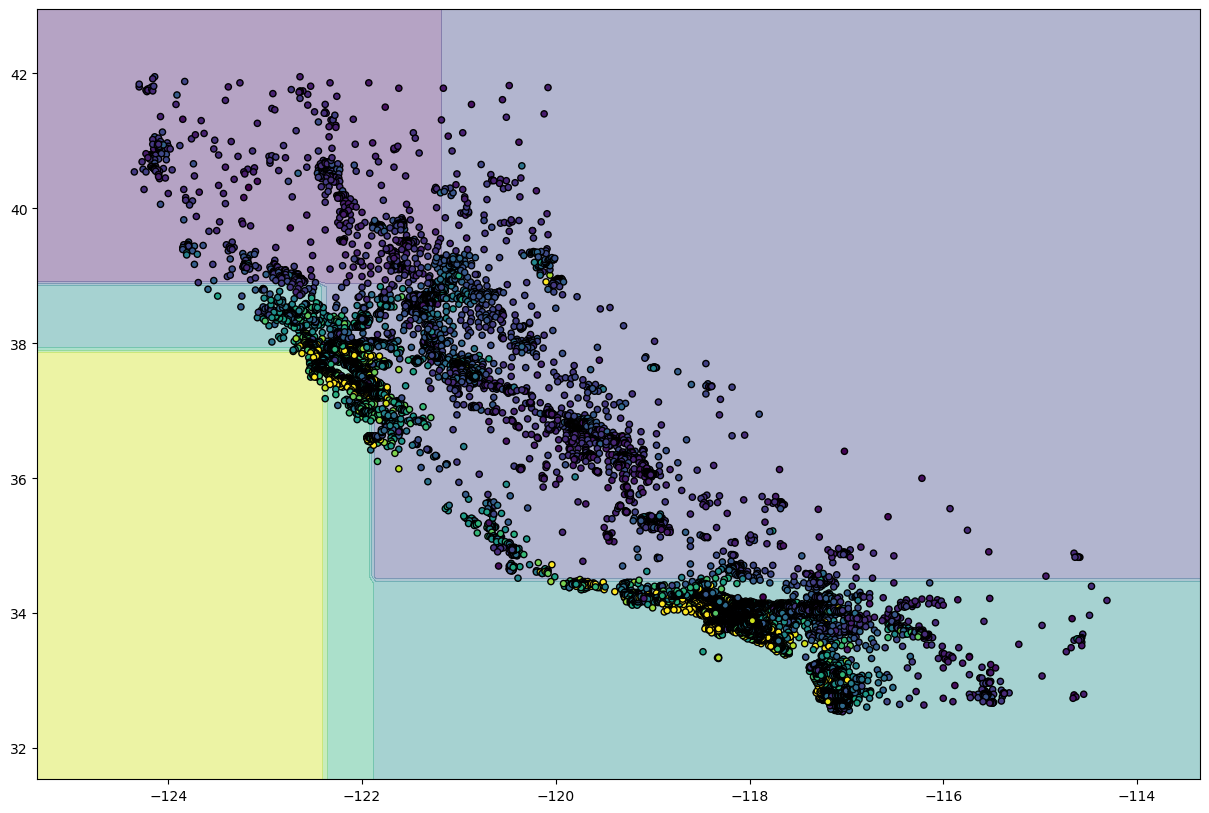

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

PlotBoundaries(tree, X,y, figsize=(15,10))

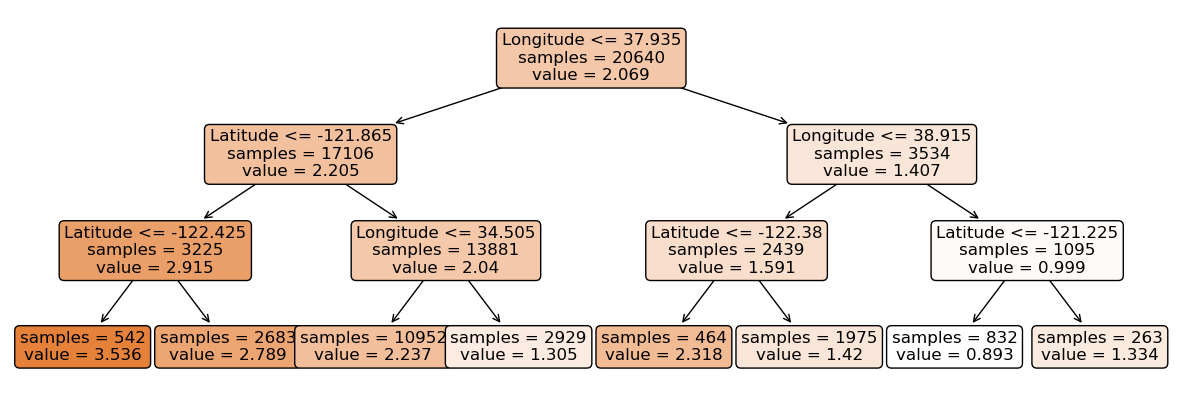

In [36]:
from sklearn.tree import plot_tree
# size for our tree figure
fig, ax = plt.subplots(figsize=(15,5))

plot_tree(tree,
          feature_names=california_df.columns[6:8],
          rounded=True,
          impurity=False,
          filled=True,
          ax=ax,
          fontsize=12);

Each leaf in the regression tree (or shaded region in the scatter plot) contains a certain set of training points. New points that fall into these leaves will have their targets predicted to be the mean value of the corresponding training points.

### But we're doing classification, how do we use this regression tree to make a categorical decision? 

Roughly speaking, like with Logistic Regression, we can just filter the continuous output through a logistic function and get back a probability which we use to make a classification. 

There is one major ramification of this. Like with logistic regression, we now need to fit a decision tree for each class. It's actually worse than this, we now need to fit a new decision tree for each class in each round of boosting! Let's fit some models to the Iris dataset, which has three classes:

In [37]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

AB_model = AdaBoostClassifier()
GB_model = GradientBoostingClassifier()

AB_model.fit(X, y);
GB_model.fit(X, y);

Now let's look at the models fitted in the first round of boosting:

In [38]:
GB_model.estimators_[0]

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x1FCB2861A40),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x1FCB2861A40),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x1FCB2861A40)],
      dtype=object)

In [39]:
AB_model.estimators_[0]

DecisionTreeClassifier(max_depth=1, random_state=1017493698)

As you can see Gradient Boosting is fitting a tree per class in each round of boosting, AdaBoost instead fits one tree per round. From here the algorithm is actually pretty similar under the hood, it just has a slightly different way of representing the models. This is a much more general learning method, it is able to simulate AdaBoost and many other boosting methods.

### XGBoost

We'll conclude our discussion of boosting with eXtreme Gradient Boosting (XGBoost). XGBoost is an implementation of Gradient Boosting which tends to be faster and more accurate than the scikit-learn implementation. It also has several modifications to the underlying fitting method which tend to help in practice. 

We can run XGBoost on the noisy cancer dataset like any other scikit-learn model. If we directly compare it against our previous tree and forest models:

In [40]:
from xgboost import XGBClassifier

cancer = load_breast_cancer()
X = cancer.data
Y = cancer.target

# Add some noise to the data (notice how I'm adding on the noise here)
random_state = np.random.RandomState(10)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 300*n_features)]

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.4, random_state=3)


XGB_model = XGBClassifier(n_jobs = -1)
XGB_model.fit(X_train, y_train)
print(f"XG Boost score: {XGB_model.score(X_test, y_test)}")

XG Boost score: 0.9649122807017544


It got the same score as scikit-learn's built in Gradient Boosting. This isn't too surprising, as this data set was simple enough that the benefits of XGBoost aren't immediately visible.

If we take a more complex dataset (the one from the previous exercise) and run various models against it:

In [41]:
data = pd.read_csv("data/db.csv")

X = data.iloc[:,0:7]
y = data.iloc[:,8]

random_state = np.random.RandomState(10)
n_samples, n_features = X.shape
X = X + (random_state.randn(n_samples, n_features))

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=3)

In [42]:
XGB_model = XGBClassifier()
AB_model = AdaBoostClassifier()
RF_model = RandomForestClassifier()

XGB_model.fit(X_train, y_train)
AB_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)

print("Test Set Scores:")
print(f"AdaBoost score: {AB_model.score(X_test, y_test)}")
print(f"Random Forest score: {RF_model.score(X_test, y_test)}")
print(f"XG Boost score: {XGB_model.score(X_test, y_test)}")

Test Set Scores:
AdaBoost score: 0.7012987012987013
Random Forest score: 0.7305194805194806
XG Boost score: 0.711038961038961


These all did almost equally well. This isn't too shocking, as all are pretty powerful methods. To see the real benefits from an accuracy standpoint, we'll probably need to throw it at a much larger dataset. However there is one area where we can see XGBoost really excels. Let's look at the fitting and prediction times of the models:

In [43]:
%%timeit
XGB_model.fit(X_train, y_train)
XGB_model.predict(X_test)

27.2 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%%timeit
AB_model.fit(X_train, y_train)
AB_model.predict(X_test)

62 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
%%timeit
RF_model.fit(X_train, y_train)
RF_model.predict(X_test)

124 ms ± 511 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


XGBoost took much less time than AdaBoost. This is a pretty huge speed up! When the datasets get larger, this increase in efficiency is extremely valuable.

### A Note about Boosting Methods

While Boosting based methods tend to work well out of the box, they often benefit from careful tuning. To understand why let's compare them to Random Forests, which don't require much tuning.

1. A Random Forest works by fitting several deep decision trees. Each tree is fitted to a random subset of the data and features. The trees are trained in parallel and their decisions are totally independent of each other. The only thing we can control for is the depth of the trees and number of trees we fit. 
2. Boosting-based methods work by fitting one model at a time. Each subsequent model is fitted to correct for the mistakes made by the previous models. In addition to the number of models and their complexity, we can control for how strong of a correction each model makes.

In general, with Random Forests we should fit as many trees as possible. Each additional tree will help to reduce the overfitting done by the other trees. The point was that the trees represent slightly biased estimates of a good model -- the more trees we add, the more we average out the variance and recover this underlying good model. If you have the time and computing power, more is better, (although we will eventually encounter diminishing marginal returns).

On the other hand for Boosting methods, if we fit too many trees we run the risk of overfitting. Furthermore we must be careful to control for how much correction each model should make, (i.e. the `learning_rate`). If this rate is too high we will end up with a poor overall model. If it is too low we will end up using a ton of trees to get a good model and fitting will take a long time.

In general, boosting methods do benefit from adjusting the underlying model parameters. The adjustments to the sub-models (complexity of the underlying decision trees) and major adjustments to the overall ensemble (number of trees or learning rate) tend to have a huge impact on performance.

### Wrapping up Decision Trees and Ensemble Methods

We'll conclude our talk of ensemble methods with a quick review of what we've seen over the course of several lectures.

1. We began with decision trees. Recall, decision trees are simple estimators which work by asking a series of simple yes/no questions. They can combine single feature linear boundaries to learn complex multiple feature non-linear boundaries. These tended to overfit to the data quite easily and we had to be careful to control for their depth. 
2. We then looked at bagging methods, specifically random forests. These randomly combine simple decision trees by averaging out their decisions. These models tend to keep most of the benefits of decision trees while also reducing their tendency to overfit. These are easy to work with and often work out of the box.
3. We finished with boosting methods. These models tend to perform even better than bagging methods, but do require some specialized tuning.

Does this mean one model is always superior to another? Not quite. While not as powerful, decision trees have one major advantage: they are easy to explain. They are easy to visualize and understand, even for people unfamiliar with data science. We can understand what patterns they have learned, even in high dimensional spaces. With Ensembles of hundreds of trees, even someone familiar with their construction would struggle to understand why they are making the decisions they make.

---
#### Exercise 2

Try to optimize XGBoost to get better performance on the previous diabetes dataset. 

*Bonus:* Take a dataset from Kaggle and see how XGBoost performs out of the box on it. Try adjusting various parameters to see if you can improve on its base performance.

---

In [46]:
data = pd.read_csv("data/db.csv")

X = data.iloc[:,0:7]
y = data.iloc[:,8]

random_state = np.random.RandomState(10)
n_samples, n_features = X.shape
X = X + (random_state.randn(n_samples, n_features))

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=3)

Solution

In [47]:
from sklearn.model_selection import GridSearchCV


my_xgb = XGBClassifier(n_jobs=-1)

param_grid = {'n_estimators': np.arange(1, 1000, 10), 'max_depth': np.arange(1, 5)}
grid_xgb = GridSearchCV(my_xgb, param_grid=param_grid, verbose=1, n_jobs=-1)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     n...
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
       261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
       391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511,
       521, 531, 541, 551, 561, 571, 581, 5

We can look at the score of the best estimator on the train and test set finally:

In [48]:
grid_xgb.score(X_train, y_train)

0.8043478260869565

In [49]:
grid_xgb.score(X_test, y_test)

0.7532467532467533

We create a data frame so we can use `seaborn` for visualization. All relevant data is stored in the `cv_results_` attribute of the `GridSearchCV` object:

In [50]:
grid_xgb.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [51]:
# we cast max_depth to str so that seaborn treats it like a category,
# which is better for visuals
results_df = pd.DataFrame({
    "n_estimators": grid_xgb.cv_results_["param_n_estimators"],
    'max_depth': grid_xgb.cv_results_["param_max_depth"].astype(str),
    'mean_score': grid_xgb.cv_results_["mean_test_score"]
})

results_df.head()

,n_estimators,max_depth,mean_score
0,1,1,0.730435
1,11,1,0.758696
2,21,1,0.769565
3,31,1,0.765217
4,41,1,0.752174


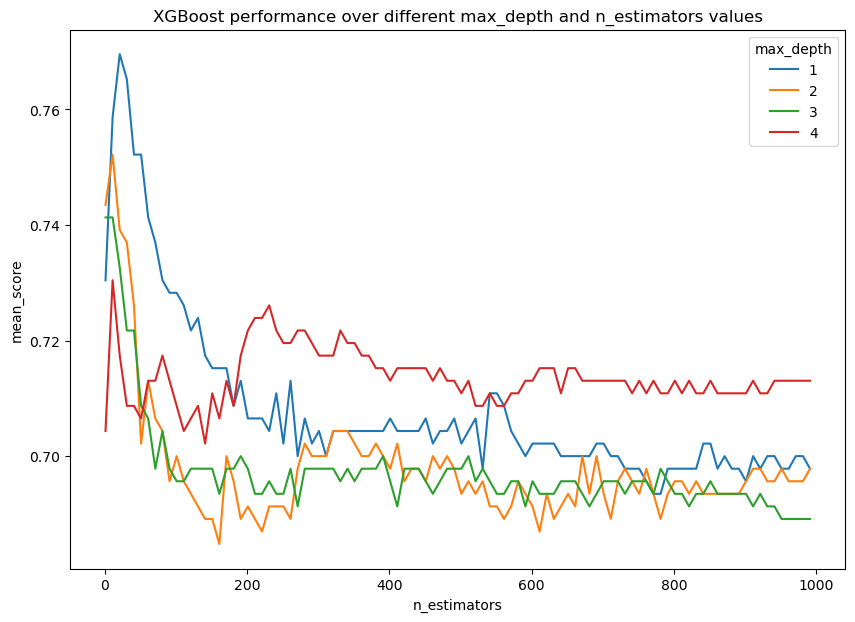

In [52]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.lineplot(x="n_estimators", y="mean_score", hue="max_depth", data=results_df)
plt.title("XGBoost performance over different max_depth and n_estimators values")
plt.show()

We can see that the best performance cames from using 21 estimators and max_depth 1 (decision stumps).

In [53]:
grid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=21, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<div id="container" style="position:relative;">
<div style="position:relative; float:right"><img style="height:25px""width: 50px" src ="https://drive.google.com/uc?export=view&id=14VoXUJftgptWtdNhtNYVm6cjVmEWpki1" />
</div>
</div>